# 台指期策略
## 1. 主策略:當股價貫穿EMA , 做多 ,當股價小於EMA  ,做空
## 2. filter : put/call ratio  TXF 未平倉淨額


In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time
path = os.getcwd()
print(path)
plt.style.use('ggplot')

C:\Users\user\Desktop\python\TMBA TXF BACKTESTING


## 資料整理
1. 合併 Date, Time
2. resample的bug?
    * 交易時間需整除，不然最後一根K看的長度會不一樣 => 1m, 3m, 5m, 10m, 15m, 30m, 60m, 1D
    * reample 1H，通常是從00:00記錄到00:00
    * resample後，沒有交易的時段會有NAN
    * 如果用K棒數來數分K：
        * 有時候夜盤沒交易的時段沒有值，會算錯根數
        * 結算日早盤交易時間少15分鐘，會算到夜盤
    * resample時間前歸後歸、開區間/閉區間的問題
3. 台指期特殊處理
    * 台指期通常慣用結束時間紀錄分K (幣圈是使用開始時間)
    * 2017-5開始有夜盤
    * 分成日盤、日夜盤兩種交易時間
    * 結算日早盤交易時間少15分鐘
    * 每月第三個禮拜三為結算日
    * 交易時段：
        * 日盤：8:46~13:45
        * 夜盤：15:01~5:00

In [2]:
df = pd.read_csv('TWF_Futures_Minute_Trade.txt') #運用 Pd.read_csv('檔案名稱要加檔案類型')
df                                               #觀察資料型態,應該要把 Date Time 變成 index 然後drop 掉

,Date,Time,Open,High,Low,Close,TotalVolume
0,2009/1/5,08:46:00,4722.0,4745.0,4714.0,4727.0,1493
1,2009/1/5,08:47:00,4727.0,4728.0,4711.0,4716.0,608
2,2009/1/5,08:48:00,4713.0,4720.0,4713.0,4716.0,400
3,2009/1/5,08:49:00,4717.0,4722.0,4715.0,4718.0,457
4,2009/1/5,08:50:00,4719.0,4721.0,4718.0,4719.0,233
...,...,...,...,...,...,...,...
1971251,2022/5/23,09:10:00,16210.0,16216.0,16206.0,16214.0,452
1971252,2022/5/23,09:11:00,16215.0,16215.0,16207.0,16210.0,224
1971253,2022/5/23,09:12:00,16210.0,16220.0,16207.0,16218.0,478
1971254,2022/5/23,09:13:00,16218.0,16220.0,16212.0,16218.0,240


In [3]:
df.index = pd.to_datetime(df['Date'] +' '+ df['Time']) 
df = df.drop(columns=['Date','Time'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['Hour'] = df.index.map(lambda x: x.hour) #把每個 HOUR 都拿出來做 列成新的
df

,open,high,low,close,volume,Hour
2009-01-05 08:46:00,4722.0,4745.0,4714.0,4727.0,1493,8
2009-01-05 08:47:00,4727.0,4728.0,4711.0,4716.0,608,8
2009-01-05 08:48:00,4713.0,4720.0,4713.0,4716.0,400,8
2009-01-05 08:49:00,4717.0,4722.0,4715.0,4718.0,457,8
2009-01-05 08:50:00,4719.0,4721.0,4718.0,4719.0,233,8
...,...,...,...,...,...,...
2022-05-23 09:10:00,16210.0,16216.0,16206.0,16214.0,452,9
2022-05-23 09:11:00,16215.0,16215.0,16207.0,16210.0,224,9
2022-05-23 09:12:00,16210.0,16220.0,16207.0,16218.0,478,9
2022-05-23 09:13:00,16218.0,16220.0,16212.0,16218.0,240,9


### reample
* 注意
    * 台指期的 9:01 是指 9:00 ~ 9:01
    * 因此 9:03 的 3分K 應為 9:01 ~ 9:03
    * label='left' 顯示方式轉為整點開始

In [4]:
rule = '3T'
Morning = df[(df['Hour'] >= 8) & (df['Hour'] <= 13)]
Morning.index = Morning.index + dt.timedelta(minutes=15)
Morning.iloc[0:8]

,open,high,low,close,volume,Hour
2009-01-05 09:01:00,4722.0,4745.0,4714.0,4727.0,1493,8
2009-01-05 09:02:00,4727.0,4728.0,4711.0,4716.0,608,8
2009-01-05 09:03:00,4713.0,4720.0,4713.0,4716.0,400,8
2009-01-05 09:04:00,4717.0,4722.0,4715.0,4718.0,457,8
2009-01-05 09:05:00,4719.0,4721.0,4718.0,4719.0,233,8
2009-01-05 09:06:00,4720.0,4725.0,4719.0,4719.0,319,8
2009-01-05 09:07:00,4721.0,4722.0,4716.0,4718.0,316,8
2009-01-05 09:08:00,4717.0,4719.0,4712.0,4715.0,263,8


In [5]:
# 確認 9:03 及 9:06 的 open 是 9:01 及 9:04 的 open
Morning.resample(rule=rule, closed='right', label='right').first()[['open']].iloc[0:3]

,open
2009-01-05 09:03:00,4722.0
2009-01-05 09:06:00,4717.0
2009-01-05 09:09:00,4721.0


In [6]:
# label='left' => 時間轉為左側時間
Morning.resample(rule=rule, closed='right', label='left').first()[['open']].iloc[0:3]

,open
2009-01-05 09:00:00,4722.0
2009-01-05 09:03:00,4717.0
2009-01-05 09:06:00,4721.0


In [7]:
rule = '1D'

Morning = df[(df['Hour'] >= 8) & (df['Hour'] <= 13)]
Morning.index = Morning.index + dt.timedelta(minutes=15)

d1 = Morning.resample(rule=rule, closed='right', label='left').first()[['open']]
d2 = Morning.resample(rule=rule, closed='right', label='left').max()[['high']]
d3 = Morning.resample(rule=rule, closed='right', label='left').min()[['low']]
d4 = Morning.resample(rule=rule, closed='right', label='left').last()[['close']]
d5 = Morning.resample(rule=rule, closed='right', label='left').sum()[['volume']]

df_Morning = pd.concat([d1,d2,d3,d4,d5], axis=1)
df_Morning = df_Morning.dropna()
df_Morning.index.name = 'Date'
df_Morning.head()
# rule = '60T'

# Morning = df[(df['Hour'] >= 8) & (df['Hour'] <= 13)]
# Morning.index = Morning.index + dt.timedelta(minutes=15)

# d1 = Morning.resample(rule=rule, closed='right', label='left').first()[['open']]
# d2 = Morning.resample(rule=rule, closed='right', label='left').max()[['high']]
# d3 = Morning.resample(rule=rule, closed='right', label='left').min()[['low']]
# d4 = Morning.resample(rule=rule, closed='right', label='left').last()[['close']]
# d5 = Morning.resample(rule=rule, closed='right', label='left').sum()[['volume']]

# df_Morning = pd.concat([d1,d2,d3,d4,d5], axis=1)
# df_Morning = df_Morning.dropna()
# df_Morning.index = df_Morning.index - dt.timedelta(minutes=15)
# df_Morning.head()

,open,high,low,close,volume
Date,,,,,
2009-01-05,4722.0,4797.0,4634.0,4670.0,97869
2009-01-06,4699.0,4735.0,4638.0,4706.0,90227
2009-01-07,4758.0,4802.0,4711.0,4752.0,90777
2009-01-08,4650.0,4650.0,4434.0,4452.0,95219
2009-01-09,4447.0,4495.0,4405.0,4425.0,90291


# 資料加入put call ratio

In [8]:
#下載資料套件
import urllib3
from bs4 import BeautifulSoup

#資料處理套件
import pandas as pd
from datetime import datetime, date, timedelta

#畫圖套件
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
pc_ratio = pd.read_csv('pc_ratio.csv')
data = pc_ratio[['Date','pc_ratio']]
data = data.set_index(pd.to_datetime(data['Date'],format='%Y/%m/%d'))
data = data.drop(columns=['Date'])
data = data.loc['2009-01-05':'2022-05-23']
data

,pc_ratio
Date,
2009-01-05,66.79
2009-01-06,68.42
2009-01-07,70.11
2009-01-08,64.57
2009-01-09,64.13
...,...
2022-05-17,96.15
2022-05-18,103.66
2022-05-19,88.47


# 合併台期日資料+pc_ratio

In [10]:
data = pd.concat([df_Morning,data],axis = 1)
data.tail(30)

,open,high,low,close,volume,pc_ratio
Date,,,,,,
2022-04-11,17222.0,17298.0,16976.0,17039.0,127779.0,87.73
2022-04-12,16960.0,17068.0,16906.0,16999.0,107319.0,92.05
2022-04-13,17080.0,17321.0,17071.0,17316.0,105913.0,105.35
2022-04-14,17349.0,17352.0,17251.0,17298.0,72448.0,102.96
2022-04-15,17102.0,17117.0,16960.0,16983.0,95242.0,90.76
2022-04-18,16908.0,16995.0,16813.0,16881.0,104425.0,88.25
2022-04-19,17065.0,17122.0,16988.0,17000.0,87868.0,93.89
2022-04-20,17071.0,17135.0,16992.0,17125.0,53764.0,91.38
2022-04-21,17180.0,17222.0,17090.0,17126.0,86002.0,90.28


# 加入期貨未平倉口數

In [11]:
txf = pd.read_csv('TXF.txt',encoding = 'big5',sep='\s+')
txf = txf.drop(columns=['身份別','簡稱'])
txf

,年月日,空方未平倉口數,多方未平倉口數,多空交易口數淨額
0,20090105,21627,31894,-1400
1,20090106,21313,32443,863
2,20090107,20241,34866,3498
3,20090108,21880,35805,-689
4,20090109,21146,38274,3201
...,...,...,...,...
3348,20220808,353585,175535,-17953
3349,20220809,347737,182792,13049
3350,20220810,356281,176659,-14826
3351,20220811,344316,186514,21809


In [12]:
txf.columns = [ 'Date', '空方未平倉口數', '多方未平倉口數', '多空未平倉口數淨額']
txf = txf.set_index(pd.to_datetime(txf['Date'].astype(str),format='%Y/%m/%d'))
txf = txf.loc['2009-01-05':'2022-05-23']
txf = txf.drop(columns='Date')
txf

,空方未平倉口數,多方未平倉口數,多空未平倉口數淨額
Date,,,
2009-01-05,21627,31894,-1400
2009-01-06,21313,32443,863
2009-01-07,20241,34866,3498
2009-01-08,21880,35805,-689
2009-01-09,21146,38274,3201
...,...,...,...
2022-05-17,404234,126104,6145
2022-05-18,349227,87267,6051
2022-05-19,366593,88817,-15588


# 合併資料

In [13]:
data = pd.concat([data,txf],axis = 1)
data

,open,high,low,close,volume,pc_ratio,空方未平倉口數,多方未平倉口數,多空未平倉口數淨額
Date,,,,,,,,,
2009-01-05,4722.0,4797.0,4634.0,4670.0,97869.0,66.79,21627,31894,-1400
2009-01-06,4699.0,4735.0,4638.0,4706.0,90227.0,68.42,21313,32443,863
2009-01-07,4758.0,4802.0,4711.0,4752.0,90777.0,70.11,20241,34866,3498
2009-01-08,4650.0,4650.0,4434.0,4452.0,95219.0,64.57,21880,35805,-689
2009-01-09,4447.0,4495.0,4405.0,4425.0,90291.0,64.13,21146,38274,3201
...,...,...,...,...,...,...,...,...,...
2022-05-17,15978.0,16096.0,15963.0,16075.0,76752.0,96.15,404234,126104,6145
2022-05-18,16180.0,16318.0,16159.0,16302.0,51713.0,103.66,349227,87267,6051
2022-05-19,15871.0,15965.0,15820.0,15911.0,109113.0,88.47,366593,88817,-15588


### 選擇回測資料

In [14]:
# df_Morning['Month'] = df_Morning.index.map(lambda x: x.month)
# df_Morning['Weekday'] = df_Morning.index.map(lambda x: x.weekday)+1
df_Morning['Hour'] = df_Morning.index.map(lambda x: x.hour)

In [15]:
trainData = data[(data.index >= '2011-01-01 00:00:00') & (data.index <= '2019-12-31 00:00:00')].copy()
testData = data[(data.index >= '2020-1-1 00:00:00') & (data.index <= '2022-5-22 00:00:00')].copy()
allData = pd.concat([trainData,testData])

In [16]:
trainData.isnull()

,open,high,low,close,volume,pc_ratio,空方未平倉口數,多方未平倉口數,多空未平倉口數淨額
Date,,,,,,,,,
2011-01-03,False,False,False,False,False,False,False,False,False
2011-01-04,False,False,False,False,False,False,False,False,False
2011-01-05,False,False,False,False,False,False,False,False,False
2011-01-06,False,False,False,False,False,False,False,False,False
2011-01-07,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
2019-12-25,False,False,False,False,False,False,False,False,False
2019-12-26,False,False,False,False,False,False,False,False,False
2019-12-27,False,False,False,False,False,False,False,False,False


In [17]:
testData.tail(3)

,open,high,low,close,volume,pc_ratio,空方未平倉口數,多方未平倉口數,多空未平倉口數淨額
Date,,,,,,,,,
2022-05-18,16180.0,16318.0,16159.0,16302.0,51713.0,103.66,349227,87267,6051
2022-05-19,15871.0,15965.0,15820.0,15911.0,109113.0,88.47,366593,88817,-15588
2022-05-20,16069.0,16145.0,16013.0,16135.0,85478.0,96.77,366829,97402,8316


In [18]:
allData

,open,high,low,close,volume,pc_ratio,空方未平倉口數,多方未平倉口數,多空未平倉口數淨額
Date,,,,,,,,,
2011-01-03,9000.0,9030.0,8995.0,9019.0,61365.0,128.13,58448,35745,-2538
2011-01-04,9030.0,9030.0,8974.0,8978.0,62448.0,126.30,60104,32808,-4869
2011-01-05,8967.0,9005.0,8791.0,8838.0,165831.0,117.69,58497,31203,-775
2011-01-06,8859.0,8876.0,8815.0,8869.0,82510.0,114.87,58141,30722,-346
2011-01-07,8866.0,8883.0,8727.0,8753.0,128752.0,113.53,55365,30964,2754
...,...,...,...,...,...,...,...,...,...
2022-05-16,15996.0,16044.0,15847.0,15921.0,97948.0,89.74,407341,123118,10025
2022-05-17,15978.0,16096.0,15963.0,16075.0,76752.0,96.15,404234,126104,6145
2022-05-18,16180.0,16318.0,16159.0,16302.0,51713.0,103.66,349227,87267,6051


### 取得結算日資料
* https://www.taifex.com.tw/cht/5/futIndxFSP

In [19]:
settlementDate_ = pd.read_csv('settlementDate.csv')
settlementDate_.columns = ['settlementDate', 'futures', 'settlementPrice']
settlementDate_

,settlementDate,futures,settlementPrice
0,2022/08/03,202208W1,14707
1,2022/07/27,202207W4,14887
2,2022/07/20,202207,14713
3,2022/07/13,202207W2,14384
4,2022/07/06,202207W1,14015
...,...,...,...
508,2009/12/16,200912,7752
509,2009/11/18,200911,7786
510,2009/10/21,200910,7705
511,2009/09/16,200909,7445


In [20]:
bool_ = [False if 'W' in i else True for i in settlementDate_['futures']]

In [21]:
len(list(settlementDate_[bool_]['futures']))

156

In [22]:
12*12 + 5 + 7

156

In [23]:
settlementDate = [i.replace('/','-') for i in list(settlementDate_[bool_]['settlementDate'])]

In [24]:
settlementDate = [pd.to_datetime(i).date() for i in settlementDate]

In [25]:
settlementDate[-5:]

[datetime.date(2009, 12, 16),
 datetime.date(2009, 11, 18),
 datetime.date(2009, 10, 21),
 datetime.date(2009, 9, 16),
 datetime.date(2009, 8, 19)]

## 回測架構
* 換月轉倉：結算日當天直接平倉
* 進場限制：結算日當天不進場
* 報酬計算：200 * 點數
* 手續費+滑價：單邊 600元

In [26]:
fund = 1000000
feePaid = 600
length = 15
NumStd = 1.5
K = 0.02
span =30
position = 3
# trainData['H'] = trainData['high'].shift(1).rolling(window=length, center=False).max()
# trainData['L'] = trainData['low'].shift(1).rolling(window=length, center=False).min()
# trainData['MA'] = trainData['close'].rolling(window=length, center=False).mean()
# trainData['upLine'] = trainData['MA'] + NumStd*trainData['STD']
# trainData['downLine'] = trainData['MA'] - NumStd*trainData['STD']
trainData['EMA_30'] = trainData['close'].ewm(span=span).mean()
trainData.head(30)

,open,high,low,close,volume,pc_ratio,空方未平倉口數,多方未平倉口數,多空未平倉口數淨額,EMA_30
Date,,,,,,,,,,
2011-01-03,9000.0,9030.0,8995.0,9019.0,61365.0,128.13,58448,35745,-2538,9019.000000
2011-01-04,9030.0,9030.0,8974.0,8978.0,62448.0,126.30,60104,32808,-4869,8997.816667
2011-01-05,8967.0,9005.0,8791.0,8838.0,165831.0,117.69,58497,31203,-775,8940.954832
2011-01-06,8859.0,8876.0,8815.0,8869.0,82510.0,114.87,58141,30722,-346,8921.128653
2011-01-07,8866.0,8883.0,8727.0,8753.0,128752.0,113.53,55365,30964,2754,8882.875314
2011-01-10,8753.0,8799.0,8735.0,8787.0,68285.0,113.55,53085,32142,3462,8864.118819
2011-01-11,8779.0,8950.0,8760.0,8941.0,131177.0,116.19,53929,36621,3983,8877.415920
2011-01-12,8960.0,9003.0,8945.0,8967.0,82510.0,119.64,57391,34067,-6016,8891.394255
2011-01-13,8998.0,9017.0,8916.0,8969.0,107227.0,122.77,57742,34158,-428,8902.488221


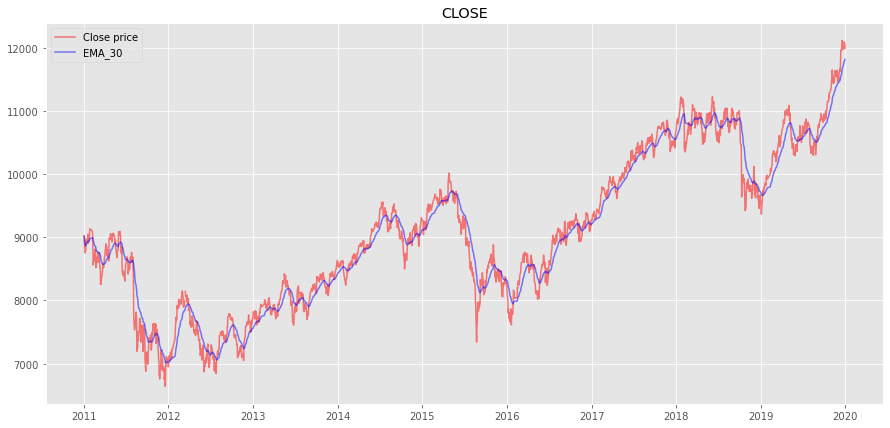

In [27]:
plt.figure(figsize = (15,7))
plt.plot(trainData['close'], color = 'red', alpha = 0.5, label = 'Close price')
plt.plot(trainData['EMA_30'], color = 'blue', alpha = 0.5, label = 'EMA_30')
plt.legend(loc='upper left')
plt.title('CLOSE');

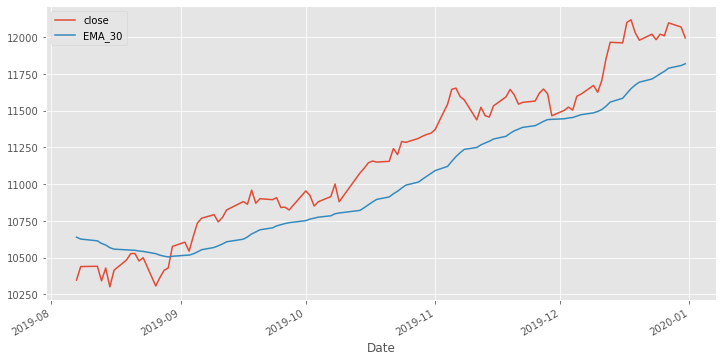

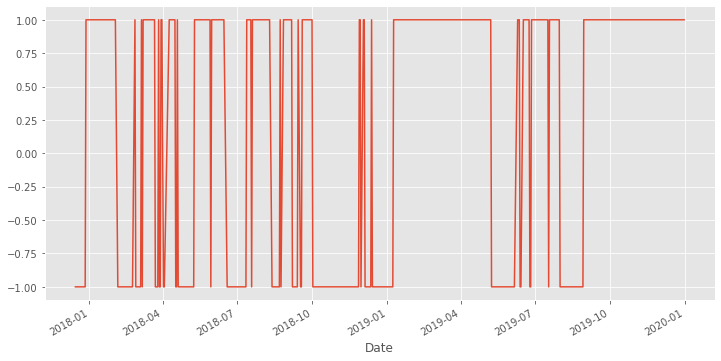

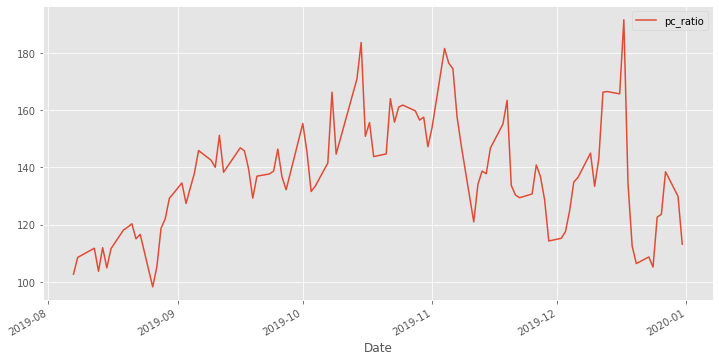

In [28]:
trainData[['close','EMA_30']][-100:].plot(figsize=(12,6))

signal = np.zeros([len(trainData)])
condition1 = (trainData['close']>trainData['EMA_30'])
condition2 = (trainData['close']<trainData['EMA_30'])
for i in range(len(trainData)): 
    if condition1[i] :
        signal[i] = 1
    elif condition2[i] :
        signal[i] = -1  
signal_df = pd.Series(signal,index = trainData.index)
plt.figure(figsize=(12,6))
signal_df[-500:].plot()
trainData[['pc_ratio']][-100:].plot(figsize=(12,6))

In [29]:
trainData['EMA_30'] = trainData['close'].ewm(span=span).mean()
testData['EMA_30']=testData['close'].ewm(span=span).mean()
allData['EMA_30']=allData['close'].ewm(span=span).mean()

In [30]:
trainData.head(3)

,open,high,low,close,volume,pc_ratio,空方未平倉口數,多方未平倉口數,多空未平倉口數淨額,EMA_30
Date,,,,,,,,,,
2011-01-03,9000.0,9030.0,8995.0,9019.0,61365.0,128.13,58448,35745,-2538,9019.000000
2011-01-04,9030.0,9030.0,8974.0,8978.0,62448.0,126.30,60104,32808,-4869,8997.816667
2011-01-05,8967.0,9005.0,8791.0,8838.0,165831.0,117.69,58497,31203,-775,8940.954832


In [31]:
testData.tail()

,open,high,low,close,volume,pc_ratio,空方未平倉口數,多方未平倉口數,多空未平倉口數淨額,EMA_30
Date,,,,,,,,,,
2022-05-16,15996.0,16044.0,15847.0,15921.0,97948.0,89.74,407341,123118,10025,16599.355250
2022-05-17,15978.0,16096.0,15963.0,16075.0,76752.0,96.15,404234,126104,6145,16565.525879
2022-05-18,16180.0,16318.0,16159.0,16302.0,51713.0,103.66,349227,87267,6051,16548.524210
2022-05-19,15871.0,15965.0,15820.0,15911.0,109113.0,88.47,366593,88817,-15588,16507.393616
2022-05-20,16069.0,16145.0,16013.0,16135.0,85478.0,96.77,366829,97402,8316,16483.368221


In [32]:
allData

,open,high,low,close,volume,pc_ratio,空方未平倉口數,多方未平倉口數,多空未平倉口數淨額,EMA_30
Date,,,,,,,,,,
2011-01-03,9000.0,9030.0,8995.0,9019.0,61365.0,128.13,58448,35745,-2538,9019.000000
2011-01-04,9030.0,9030.0,8974.0,8978.0,62448.0,126.30,60104,32808,-4869,8997.816667
2011-01-05,8967.0,9005.0,8791.0,8838.0,165831.0,117.69,58497,31203,-775,8940.954832
2011-01-06,8859.0,8876.0,8815.0,8869.0,82510.0,114.87,58141,30722,-346,8921.128653
2011-01-07,8866.0,8883.0,8727.0,8753.0,128752.0,113.53,55365,30964,2754,8882.875314
...,...,...,...,...,...,...,...,...,...,...
2022-05-16,15996.0,16044.0,15847.0,15921.0,97948.0,89.74,407341,123118,10025,16599.355250
2022-05-17,15978.0,16096.0,15963.0,16075.0,76752.0,96.15,404234,126104,6145,16565.525879
2022-05-18,16180.0,16318.0,16159.0,16302.0,51713.0,103.66,349227,87267,6051,16548.524210


# IS

In [33]:
trainData.head(3)

,open,high,low,close,volume,pc_ratio,空方未平倉口數,多方未平倉口數,多空未平倉口數淨額,EMA_30
Date,,,,,,,,,,
2011-01-03,9000.0,9030.0,8995.0,9019.0,61365.0,128.13,58448,35745,-2538,9019.000000
2011-01-04,9030.0,9030.0,8974.0,8978.0,62448.0,126.30,60104,32808,-4869,8997.816667
2011-01-05,8967.0,9005.0,8791.0,8838.0,165831.0,117.69,58497,31203,-775,8940.954832


In [34]:
df_arr = np.array(trainData)
time_arr = np.array(trainData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]

               profit  profitfee
Date                            
2011-01-03        0.0        0.0
2011-01-04        0.0        0.0
2011-01-05        0.0        0.0
2011-01-06        0.0        0.0
2011-01-07        0.0        0.0
...               ...        ...
2019-12-25  4145400.0  3792600.0
2019-12-26  4145400.0  3792600.0
2019-12-27  4145400.0  3792600.0
2019-12-30  4145400.0  3792600.0
2019-12-31  4108200.0  3751800.0

[2214 rows x 2 columns]
tradeTimes: 99


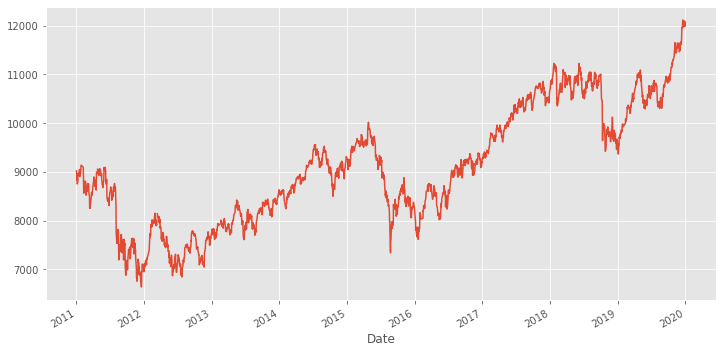

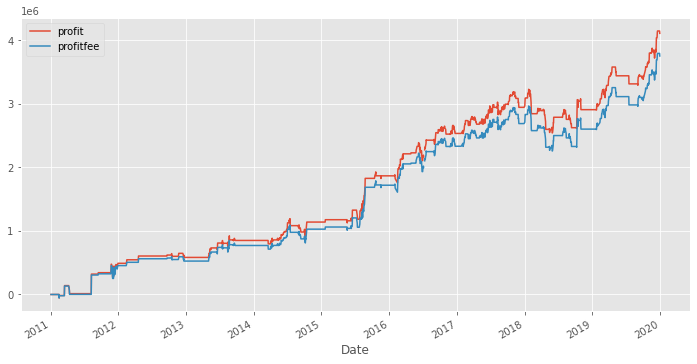

In [35]:
fund = 1000000 
feePaid = 600
K = 0.02
span =30
position = 3
pc1 =130
pc2 = 80
txf1=1000
txf2 = -1750
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = [0]

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break
        
    ## 進場邏輯
    filter_entrylong = df_arr[i,8]>=df_arr[i-1,8]
    filter_entryshort = df_arr[i,8]<=df_arr[i-1,8]<=df_arr[i-2,8] and df_arr[i-2,8]<=-(txf2)
    entryLong = df_arr[i,3] > df_arr[i,9] and df_arr[i,5]>=df_arr[i-1,5]>=df_arr[i-2,5]and df_arr[i,5]>=pc1# and filter_entrylong 
    entrySellShort = df_arr[i,3] < df_arr[i,9] and df_arr[i,5]<=pc2 and df_arr[i,5]<=df_arr[i-1,5]
    entryCondition = date_arr[i] not in settlementDate
    
    ## 出場邏輯 
    filter_exitshort = df_arr[i,8]<=df_arr[i-1,8] <=df_arr[i-2,8]
    filter_buytocover =df_arr[i,8]>=df_arr[i-1,8] >=df_arr[i-2,8]
    exitShort = df_arr[i,3] <= df_arr[i,9] and filter_exitshort
    exitBuyToCover = df_arr[i,3] >= df_arr[i,9] and filter_buytocover
    exitCondition = date_arr[i] in settlementDate #and df_arr[i,5] >= 11
    ##部位說明
    #if not(list(pd.Series(profit_fee_list_realized).cumsum()) == []):
#     if list(pd.Series(profit_fee_list_realized).cumsum())[-1]<400000:
#         position = 2
#     if 400000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<800000:
#         position = 3
#     if 800000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<1200000:
#         position = 4
#     if 1200000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<1600000:
#         position = 5
#     if 1600000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<2000000:
#         position = 6
#     if 2000000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<2400000:
#         position = 7 
#     if 2400000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<2800000:
#         position = 8
#     if 2800000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<3200000:
#         position = 9
#     if 3200000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<3600000:
#         position = 10
#     if 3600000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<4000000:
#         position = 11
#     if 4000000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<4400000:
#         position = 12
#     if 4400000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<4800000:
#         position = 13
    ##不交易
    
    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K)
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K) 
    elif BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+K)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K) 

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        
        if entryLong and entryCondition:
            BS = 'B'
            t = i+1
            buy.append(t)

        elif entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            sellshort.append(t)
            
    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])*position
        profit_list.append(profit)
            
        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])*position
            profit_fee = profit - feePaid*2*position
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2*position
            profit_fee_list_realized.append(profit_fee_realized)
             
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
    elif BS == 'S': 
        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])*position
        profit_list.append(profit)
        
        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])*position
            profit_fee = profit - feePaid*2*position
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2*position
            profit_fee_list_realized.append(profit_fee_realized)
 
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
            
equity = pd.DataFrame([list(pd.Series(profit_list).cumsum()),list(pd.Series(profit_fee_list).cumsum())]).T
tradeTimes = len(buy)+len(sellshort)
equity.index=trainData.index
equity.columns=['profit','profitfee']
print(equity)
print(f'tradeTimes: {tradeTimes}')
trainData['close'].plot(figsize=(12,6));
equity.plot(figsize=(12,6));
#std atr

In [36]:
len(buy),len(sellshort)

(73, 26)

In [37]:
trainData
trainData.to_csv(path+'/trainData.csv')
testData.to_csv(path+'/testData.csv')
allData.to_csv(path+'/allData.csv')

In [38]:
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
equity['equity_percent'] = equity['equity'].pct_change(1)

In [39]:
equity

,profit,profitfee,equity,drawdown_percent,drawdown,equity_percent
Date,,,,,,
2011-01-03,0.0,0.0,1000000.0,0.000000,0.0,NaN
2011-01-04,0.0,0.0,1000000.0,0.000000,0.0,0.000000
2011-01-05,0.0,0.0,1000000.0,0.000000,0.0,0.000000
2011-01-06,0.0,0.0,1000000.0,0.000000,0.0,0.000000
2011-01-07,0.0,0.0,1000000.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...
2019-12-25,4145400.0,3792600.0,4792600.0,0.000000,0.0,0.000000
2019-12-26,4145400.0,3792600.0,4792600.0,0.000000,0.0,0.000000
2019-12-27,4145400.0,3792600.0,4792600.0,0.000000,0.0,0.000000


In [40]:
profit = equity['profitfee'].iloc[-1]
ret = (equity['equity'][-1]/equity['equity'][0]) - 1
annual_ret = ret/10
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = len(buy)+len(sellshort)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i > 0]) / abs(sum([i for i in profit_fee_list_realized if i < 0]))
winLossRatio = np.mean([i for i in profit_fee_list_realized if i > 0]) / abs(np.mean([i for i in profit_fee_list_realized if i < 0]))
annuallize_std = equity['equity_percent'].std()*(252**0.5)
sharpRatio = annual_ret/ annuallize_std
風報比 = annual_ret/mdd

print(f'tradeTimes: {tradeTimes}')
print(f'profit: ${np.round(profit,2)}')
print(f'return: {np.round(ret,4)*100}%')
print(f'annualReturn:{np.round(annual_ret,4)*100}%')
print(f'mdd: {np.round(mdd,4)*100}%')
print(f'annuallize_std: {np.round(annuallize_std,4)*100}%')
print(f'sharpRatio: {np.round(sharpRatio,2)}')
print(f'風報比: {np.round(風報比,2)}')
print(f'winRate: {np.round(winRate,4)*100}%')
print(f'profitFactor: {np.round(profitFactor,2)}')
print(f'winLossRatio: {np.round(winLossRatio,2)}')



#sharpratio
#win percentage

tradeTimes: 99
profit: $3751800.0
return: 375.18%
annualReturn:37.519999999999996%
mdd: 17.88%
annuallize_std: 18.37%
sharpRatio: 2.04
風報比: 2.1
winRate: 63.0%
profitFactor: 2.22
winLossRatio: 1.27


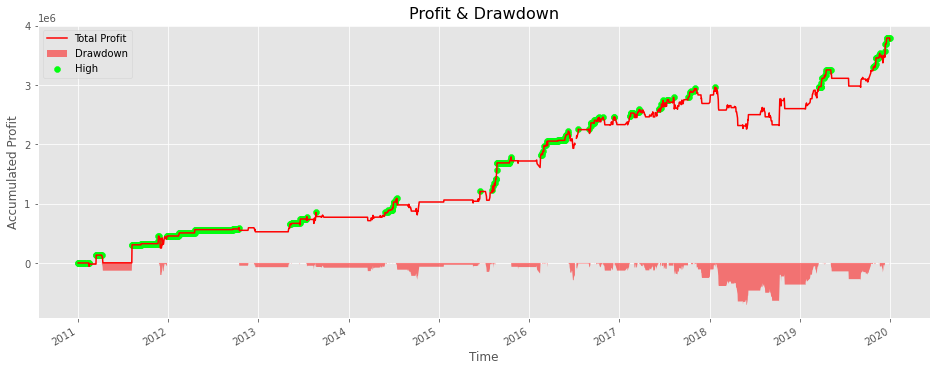

In [41]:
fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profitfee'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);

# oos

In [42]:
df_arrt = np.array(testData)
time_arr = np.array(testData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]

In [43]:
testData

,open,high,low,close,volume,pc_ratio,空方未平倉口數,多方未平倉口數,多空未平倉口數淨額,EMA_30
Date,,,,,,,,,,
2020-01-02,12044.0,12120.0,12023.0,12102.0,100399.0,127.11,89338,96305,3011,12102.000000
2020-01-03,12180.0,12198.0,11996.0,12086.0,172648.0,121.91,89477,95478,-966,12093.733333
2020-01-06,12017.0,12034.0,11948.0,11950.0,118371.0,99.09,94625,93926,-6700,12042.593854
2020-01-07,11995.0,12009.0,11816.0,11871.0,157259.0,89.28,95248,90463,-4050,11995.313494
2020-01-08,11728.0,11892.0,11697.0,11788.0,158049.0,105.88,89342,97811,13307,11948.144655
...,...,...,...,...,...,...,...,...,...,...
2022-05-16,15996.0,16044.0,15847.0,15921.0,97948.0,89.74,407341,123118,10025,16599.355250
2022-05-17,15978.0,16096.0,15963.0,16075.0,76752.0,96.15,404234,126104,6145,16565.525879
2022-05-18,16180.0,16318.0,16159.0,16302.0,51713.0,103.66,349227,87267,6051,16548.524210


29
               profit  profitfee
Date                            
2020-01-02        0.0        0.0
2020-01-03        0.0        0.0
2020-01-06        0.0        0.0
2020-01-07        0.0        0.0
2020-01-08        0.0        0.0
...               ...        ...
2022-05-16  2386600.0  2285800.0
2022-05-17  2390200.0  2289400.0
2022-05-18  2349800.0  2249000.0
2022-05-19  2411600.0  2307200.0
2022-05-20  2411600.0  2307200.0

[578 rows x 2 columns]


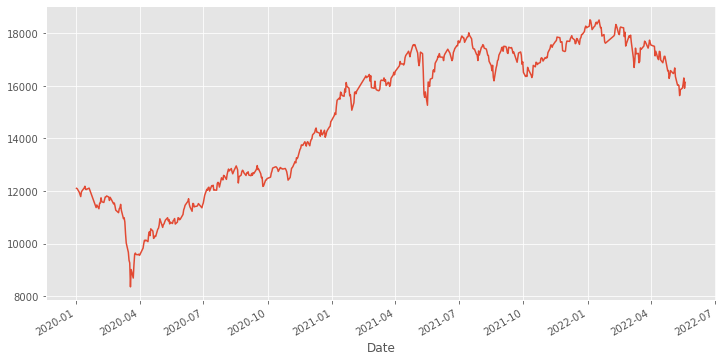

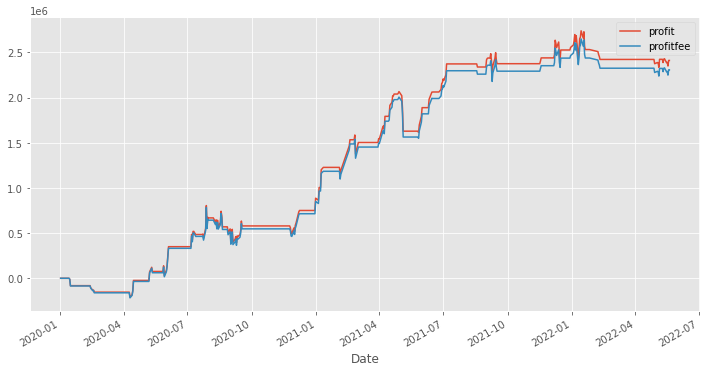

In [45]:
fund = 1000000
feePaid = 600
K = 0.02
span =30
position = 3
pc1 =130
pc2 = 80
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = [0]

for i in range(len(df_arrt)):

    if i == len(df_arrt)-1:
        break
#     if not(list(pd.Series(profit_fee_list_realized).cumsum()) == []):
#     if list(pd.Series(profit_fee_list_realized).cumsum())[-1]<400000:
#         position = 2
#     if 400000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<800000:
#         position = 3
#     if 800000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<1200000:
#         position = 4
#     if 1200000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<1600000:
#         position = 5
#     if 1600000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<2000000:
#         position = 5
#     if 2000000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<2400000:
#         position = 6 
#     if 2400000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<2800000:
#         position = 7
#     if 2800000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<3200000:
#         position = 8
#     if 3200000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<3600000:
#         position = 9
#     if 3600000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<4000000:
#         position = 10
#     if 4000000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<4400000:
#         position = 11
#     if 4400000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<4800000:
#         position = 12
    ## 進場邏輯
    filter_entrylong = df_arr[i,8]>=df_arr[i-1,8]
    filter_entryshort = df_arrt[i,8]<0 and df_arrt[i,8]<=df_arrt[i-1,8]
    entryLong = df_arrt[i,3] > df_arrt[i,9] and df_arrt[i,5]>=df_arrt[i-1,5]>=df_arrt[i-2,5]and df_arrt[i,5]>=pc1# and filter_entrylong
    entrySellShort = df_arrt[i,3] < df_arrt[i,9] and df_arrt[i,5]<=pc2 and df_arrt[i,5]<=df_arrt[i-1,5]
    entryCondition = date_arr[i] not in settlementDate
    
    ## 出場邏輯
    filter_exitshort = df_arrt[i,8]<=df_arrt[i-1,8] <=df_arrt[i-2,8]
    filter_buytocover = df_arrt[i,8]>=df_arrt[i-1,8] >=df_arrt[i-2,8]
    exitShort = df_arrt[i,3] <= df_arrt[i,9] and filter_exitshort
    exitBuyToCover = df_arrt[i,3] >= df_arrt[i,9] and filter_buytocover
    exitCondition = date_arr[i] in settlementDate #and df_arr[i,5] >= 11
    
    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = df_arrt[i,3] <= df_arrt[t,0] * (1-K)
        stopProfit = df_arrt[i,3] >= df_arrt[t,0] * (1+K)
    elif BS == 'S':
        stopLoss = df_arrt[i,3] >= df_arrt[t,0] * (1+K)
        stopProfit = df_arrt[i,3] <= df_arrt[t,0] * (1-K)

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        
        if entryLong and entryCondition:
            BS = 'B'
            t = i+1
            buy.append(t)

        elif entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            sellshort.append(t)
            
    elif BS == 'B':
        profit = 200 * (df_arrt[i+1,0] - df_arrt[i,0])*position
        profit_list.append(profit)
            
        if exitShort or i == len(df_arrt)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arrt[i+1,0] - df_arrt[t,0])*position
            profit_fee = profit - feePaid*2*position
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2*position
            profit_fee_list_realized.append(profit_fee_realized)
             
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
    elif BS == 'S': 
        profit = 200 * (df_arrt[i,0] - df_arrt[i+1,0])
        profit_list.append(profit)
        
        if exitBuyToCover or i == len(df_arrt)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arrt[t,0] - df_arrt[i+1,0])
            profit_fee = profit - feePaid*2*position
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2*position
            profit_fee_list_realized.append(profit_fee_realized)
 
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
            
equity = pd.DataFrame([list(pd.Series(profit_list).cumsum()),list(pd.Series(profit_fee_list).cumsum())]).T
equity.index=testData.index
equity.columns=['profit','profitfee']
tradeTimes = len(buy)+len(sellshort)
print(tradeTimes)
print(equity)
testData['close'].plot(grid=True, figsize=(12,6));
equity.plot(grid=True, figsize=(12,6));

In [46]:
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
equity['equity_percent'] = equity['equity'].pct_change(1)

In [47]:
profit = equity['profitfee'].iloc[-1]
ret = (equity['equity'][-1]/equity['equity'][0]) - 1
annual_ret = ret/2
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = len(buy)+len(sellshort)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i > 0]) / abs(sum([i for i in profit_fee_list_realized if i < 0]))
winLossRatio = np.mean([i for i in profit_fee_list_realized if i > 0]) / abs(np.mean([i for i in profit_fee_list_realized if i < 0]))
annuallize_std = equity['equity_percent'].std()*(252**0.5)
sharpRatio = annual_ret/ annuallize_std
風報比 = annual_ret/mdd

print(f'tradeTimes: {tradeTimes}')
print(f'profit: ${np.round(profit,2)}')
print(f'return: {np.round(ret,4)*100}%')
print(f'annualReturn:{np.round(annual_ret,4)*100}%')
print(f'mdd: {np.round(mdd,4)*100}%')
print(f'annuallize_std: {np.round(annuallize_std,4)*100}%')
print(f'sharpRatio: {np.round(sharpRatio,2)}')
print(f'風報比: {np.round(風報比,2)}')
print(f'winRate: {np.round(winRate,4)*100}%')
print(f'profitFactor: {np.round(profitFactor,2)}')
print(f'winLossRatio: {np.round(winLossRatio,2)}')


tradeTimes: 29
profit: $2307200.0
return: 230.72%
annualReturn:115.36%
mdd: 23.48%
annuallize_std: 37.769999999999996%
sharpRatio: 3.05
風報比: 4.91
winRate: 66.67%
profitFactor: 3.62
winLossRatio: 1.63


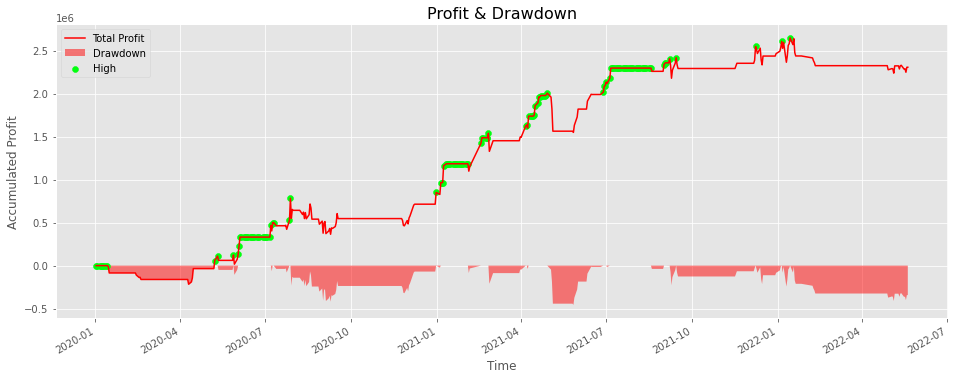

In [48]:
fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profitfee'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);

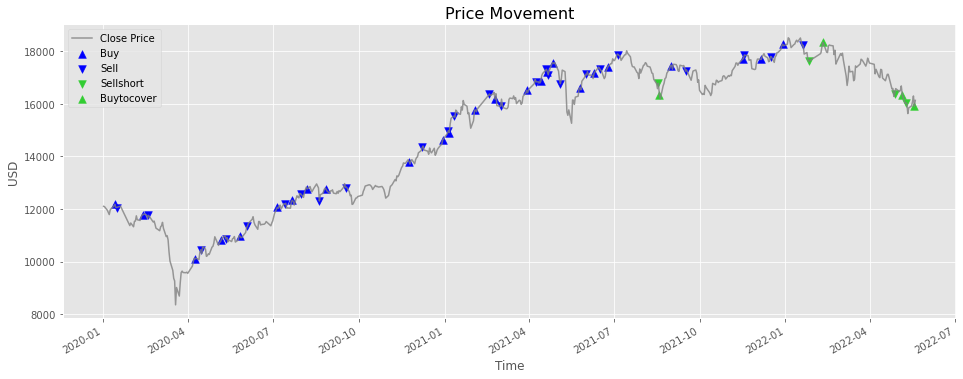

In [49]:
fig, ax = plt.subplots(figsize = (16,6))

testData['close'].plot(label = 'Close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(testData['close'].iloc[buy].index, testData['close'].iloc[buy],c = 'blue', label = 'Buy', marker='^', s=60)
plt.scatter(testData['close'].iloc[sell].index, testData['close'].iloc[sell],c = 'blue', label = 'Sell', marker='v', s=60)
plt.scatter(testData['close'].iloc[sellshort].index, testData['close'].iloc[sellshort],c = 'limegreen', label = 'Sellshort', marker='v', s=60)
plt.scatter(testData['close'].iloc[buytocover].index, testData['close'].iloc[buytocover],c = 'limegreen', label = 'Buytocover', marker='^', s=60)

plt.legend()
plt.ylabel('USD')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

# 全樣本回測

In [50]:
allData

,open,high,low,close,volume,pc_ratio,空方未平倉口數,多方未平倉口數,多空未平倉口數淨額,EMA_30
Date,,,,,,,,,,
2011-01-03,9000.0,9030.0,8995.0,9019.0,61365.0,128.13,58448,35745,-2538,9019.000000
2011-01-04,9030.0,9030.0,8974.0,8978.0,62448.0,126.30,60104,32808,-4869,8997.816667
2011-01-05,8967.0,9005.0,8791.0,8838.0,165831.0,117.69,58497,31203,-775,8940.954832
2011-01-06,8859.0,8876.0,8815.0,8869.0,82510.0,114.87,58141,30722,-346,8921.128653
2011-01-07,8866.0,8883.0,8727.0,8753.0,128752.0,113.53,55365,30964,2754,8882.875314
...,...,...,...,...,...,...,...,...,...,...
2022-05-16,15996.0,16044.0,15847.0,15921.0,97948.0,89.74,407341,123118,10025,16599.355250
2022-05-17,15978.0,16096.0,15963.0,16075.0,76752.0,96.15,404234,126104,6145,16565.525879
2022-05-18,16180.0,16318.0,16159.0,16302.0,51713.0,103.66,349227,87267,6051,16548.524210


In [51]:
df_arr = np.array(allData)
time_arr = np.array(allData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]

               profit  profitfee
Date                            
2011-01-03        0.0        0.0
2011-01-04        0.0        0.0
2011-01-05        0.0        0.0
2011-01-06        0.0        0.0
2011-01-07        0.0        0.0
...               ...        ...
2022-05-16  5962200.0  5508600.0
2022-05-17  5973000.0  5519400.0
2022-05-18  5851800.0  5398200.0
2022-05-19  6037200.0  5580000.0
2022-05-20  6037200.0  5580000.0

[2792 rows x 2 columns]
tradeTimes: 127


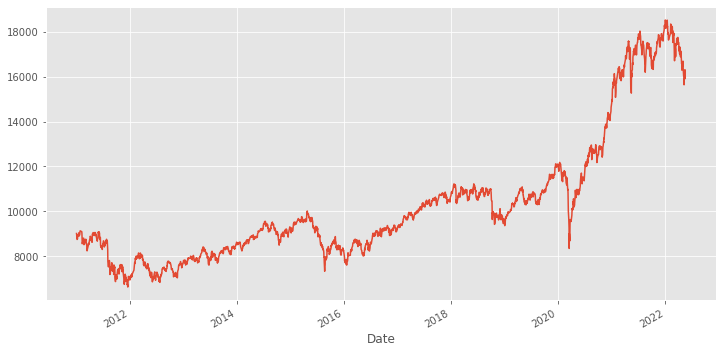

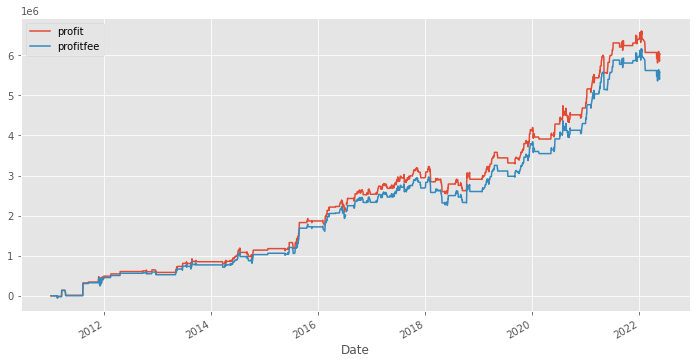

In [54]:
fund = 1000000
feePaid = 600
K = 0.02
span =30
position = 3
pc1 =130
pc2 = 80
txf1=1000
txf2 = -1750
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = [0]

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break
        
    ## 進場邏輯
    filter_entrylong = df_arr[i,8]>=df_arr[i-1,8]
    filter_entryshort = df_arr[i,8]<=df_arr[i-1,8]<=df_arr[i-2,8] and df_arr[i-2,8]<=-(txf2)
    entryLong = df_arr[i,3] > df_arr[i,9] and df_arr[i,5]>=df_arr[i-1,5]>=df_arr[i-2,5]and df_arr[i,5]>=pc1# and filter_entrylong 
    entrySellShort = df_arr[i,3] < df_arr[i,9] and df_arr[i,5]<=pc2 and df_arr[i,5]<=df_arr[i-1,5]
    entryCondition = date_arr[i] not in settlementDate
    
    ## 出場邏輯 
    filter_exitshort = df_arr[i,8]<=df_arr[i-1,8] <=df_arr[i-2,8]
    filter_buytocover = df_arr[i,8]>=df_arr[i-1,8] >=df_arr[i-2,8]
    exitShort = df_arr[i,3] <= df_arr[i,9] and filter_exitshort
    exitBuyToCover = df_arr[i,3] >= df_arr[i,9] and filter_buytocover
    exitCondition = date_arr[i] in settlementDate #and df_arr[i,5] >= 11
    ##部位說明
    #if not(list(pd.Series(profit_fee_list_realized).cumsum()) == []):
#     if list(pd.Series(profit_fee_list_realized).cumsum())[-1]<400000:
#         position = 2
#     if 400000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<800000:
#         position = 3
#     if 800000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<1200000:
#         position = 4
#     if 1200000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<1600000:
#         position = 5
#     if 1600000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<2000000:
#         position = 6
#     if 2000000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<2400000:
#         position = 7 
#     if 2400000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<2800000:
#         position = 8
#     if 2800000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<3200000:
#         position = 9
#     if 3200000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<3600000:
#         position = 10
#     if 3600000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<4000000:
#         position = 11
#     if 4000000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<4400000:
#         position = 12
#     if 4400000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<4800000:
#         position = 13
    ##不交易
    
    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K)
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
    elif BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+K)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        
        if entryLong and entryCondition:
            BS = 'B'
            t = i+1
            buy.append(t)

        elif entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            sellshort.append(t)
            
    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])*position
        profit_list.append(profit)
            
        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])*position
            profit_fee = profit - feePaid*2*position
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2*position
            profit_fee_list_realized.append(profit_fee_realized)
             
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
    elif BS == 'S': 
        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])*position
        profit_list.append(profit)
        
        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])*position
            profit_fee = profit - feePaid*2*position
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2*position
            profit_fee_list_realized.append(profit_fee_realized)
 
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
            
equity = pd.DataFrame([list(pd.Series(profit_list).cumsum()),list(pd.Series(profit_fee_list).cumsum())]).T
tradeTimes = len(buy)+len(sellshort)
equity.index=allData.index
equity.columns=['profit','profitfee']
print(equity)
print(f'tradeTimes: {tradeTimes}')
allData['close'].plot(grid=True, figsize=(12,6));
equity.plot(grid=True, figsize=(12,6));
#std atr

In [55]:
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
equity['equity_percent'] = equity['equity'].pct_change(1)

In [56]:
equity

,profit,profitfee,equity,drawdown_percent,drawdown,equity_percent
Date,,,,,,
2011-01-03,0.0,0.0,1000000.0,0.000000,0.0,NaN
2011-01-04,0.0,0.0,1000000.0,0.000000,0.0,0.000000
2011-01-05,0.0,0.0,1000000.0,0.000000,0.0,0.000000
2011-01-06,0.0,0.0,1000000.0,0.000000,0.0,0.000000
2011-01-07,0.0,0.0,1000000.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...
2022-05-16,5962200.0,5508600.0,6508600.0,-0.091384,-654600.0,-0.019789
2022-05-17,5973000.0,5519400.0,6519400.0,-0.089876,-643800.0,0.001659
2022-05-18,5851800.0,5398200.0,6398200.0,-0.106796,-765000.0,-0.018591


In [57]:
profit = equity['profitfee'].iloc[-1]
ret = (equity['equity'][-1]/equity['equity'][0]) - 1
annual_ret = ret/12
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = len(buy)+len(sellshort)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i > 0]) / abs(sum([i for i in profit_fee_list_realized if i < 0]))
winLossRatio = np.mean([i for i in profit_fee_list_realized if i > 0]) / abs(np.mean([i for i in profit_fee_list_realized if i < 0]))
annuallize_std = equity['equity_percent'].std()*(252**0.5)
sharpRatio = annual_ret/ annuallize_std
風報比 = annual_ret/mdd

print(f'tradeTimes: {tradeTimes}')
print(f'profit: ${np.round(profit,2)}')
print(f'return: {np.round(ret,4)*100}%')
print(f'annualReturn:{np.round(annual_ret,4)*100}%')
print(f'mdd: {np.round(mdd,4)*100}%')
print(f'annuallize_std: {np.round(annuallize_std,4)*100}%')
print(f'sharpRatio: {np.round(sharpRatio,2)}')
print(f'風報比: {np.round(風報比,2)}')
print(f'winRate: {np.round(winRate,4)*100}%')
print(f'profitFactor: {np.round(profitFactor,2)}')
print(f'winLossRatio: {np.round(winLossRatio,2)}')


tradeTimes: 127
profit: $5580000.0
return: 558.0%
annualReturn:46.5%
mdd: 17.88%
annuallize_std: 17.47%
sharpRatio: 2.66
風報比: 2.6
winRate: 64.84%
profitFactor: 2.29
winLossRatio: 1.21


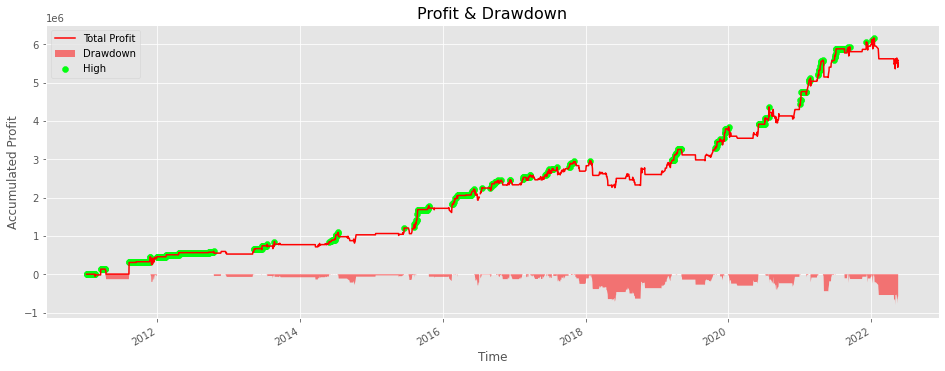

In [58]:
fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profitfee'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);

# 多空單績效

## 多單績效

In [59]:
df_arr = np.array(allData)
time_arr = np.array(allData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]

               profit  profitfee
Date                            
2011-01-03        0.0        0.0
2011-01-04        0.0        0.0
2011-01-05        0.0        0.0
2011-01-06        0.0        0.0
2011-01-07        0.0        0.0
...               ...        ...
2022-05-16  4577400.0  4228200.0
2022-05-17  4577400.0  4228200.0
2022-05-18  4577400.0  4228200.0
2022-05-19  4577400.0  4228200.0
2022-05-20  4577400.0  4228200.0

[2792 rows x 2 columns]
tradeTimes: 97


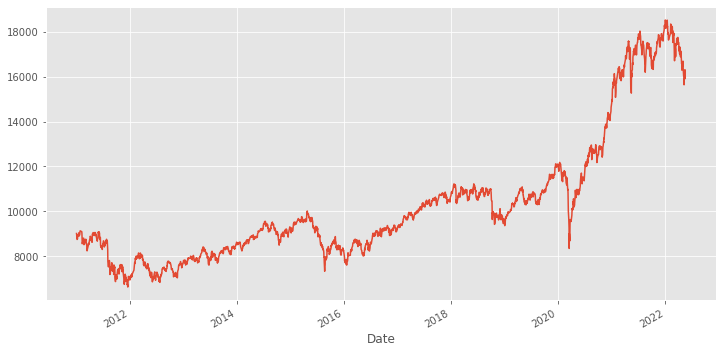

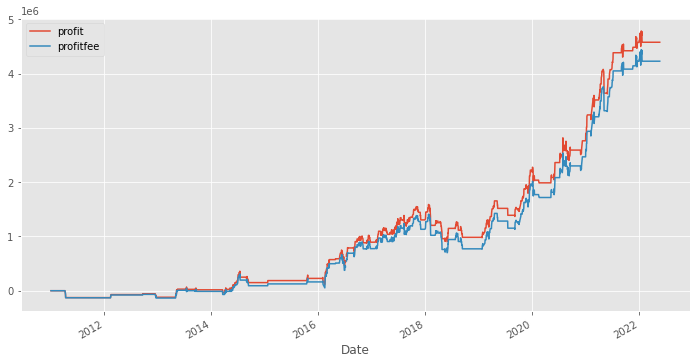

In [60]:
fund = 1000000
feePaid = 600
K = 0.02
span =30
position = 3
pc1 =130
pc2 = 80
txf1=1000
txf2 = -1750
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = [0]

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break
        
    ## 進場邏輯
    filter_entrylong = df_arr[i,8]>=df_arr[i-1,8]
    filter_entryshort = df_arr[i,8]<=df_arr[i-1,8]<=df_arr[i-2,8] and df_arr[i-2,8]<=-(txf2)
    entryLong = df_arr[i,3] > df_arr[i,9] and df_arr[i,5]>=df_arr[i-1,5]>=df_arr[i-2,5]and df_arr[i,5]>=pc1# and filter_entrylong 
    entrySellShort = df_arr[i,3] < df_arr[i,9] and df_arr[i,5]<=pc2 and df_arr[i,5]<=df_arr[i-1,5]
    entryCondition = date_arr[i] not in settlementDate
    
    ## 出場邏輯 
    filter_exitshort = df_arr[i,8]<=df_arr[i-1,8] <=df_arr[i-2,8]
    filter_buytocover =df_arr[i,8]>=df_arr[i-1,8] >=df_arr[i-2,8]
    exitShort = df_arr[i,3] <= df_arr[i,9]  and filter_exitshort
    exitBuyToCover = df_arr[i,3] >= df_arr[i,9] and filter_buytocover
    exitCondition = date_arr[i] in settlementDate #and df_arr[i,5] >= 11
    ##部位說明
    #if not(list(pd.Series(profit_fee_list_realized).cumsum()) == []):
#     if list(pd.Series(profit_fee_list_realized).cumsum())[-1]<400000:
#         position = 2
#     if 400000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<800000:
#         position = 3
#     if 800000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<1200000:
#         position = 4
#     if 1200000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<1600000:
#         position = 5
#     if 1600000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<2000000:
#         position = 6
#     if 2000000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<2400000:
#         position = 7 
#     if 2400000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<2800000:
#         position = 8
#     if 2800000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<3200000:
#         position = 9
#     if 3200000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<3600000:
#         position = 10
#     if 3600000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<4000000:
#         position = 11
#     if 4000000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<4400000:
#         position = 12
#     if 4400000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<4800000:
#         position = 13
    ##不交易
    
    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K)
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
    elif BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+K)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        
        if entryLong and entryCondition:
            BS = 'B'
            t = i+1
            buy.append(t)

#         elif entrySellShort and entryCondition:
#             BS = 'S'
#             t = i+1
#             sellshort.append(t)
            
    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])*position
        profit_list.append(profit)
            
        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])*position
            profit_fee = profit - feePaid*2*position
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2*position
            profit_fee_list_realized.append(profit_fee_realized)
             
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
    elif BS == 'S': 
        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])*position
        profit_list.append(profit)
        
        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])*position
            profit_fee = profit - feePaid*2*position
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2*position
            profit_fee_list_realized.append(profit_fee_realized)
 
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
            
equity = pd.DataFrame([list(pd.Series(profit_list).cumsum()),list(pd.Series(profit_fee_list).cumsum())]).T
tradeTimes = len(buy)+len(sellshort)
equity.index=allData.index
equity.columns=['profit','profitfee']
print(equity)
print(f'tradeTimes: {tradeTimes}')
allData['close'].plot(grid=True, figsize=(12,6));
equity.plot(grid=True, figsize=(12,6));
#std atr

## 空單績效

               profit  profitfee
Date                            
2011-01-03        0.0        0.0
2011-01-04        0.0        0.0
2011-01-05        0.0        0.0
2011-01-06        0.0        0.0
2011-01-07        0.0        0.0
...               ...        ...
2022-05-16  1384800.0  1280400.0
2022-05-17  1395600.0  1291200.0
2022-05-18  1274400.0  1170000.0
2022-05-19  1459800.0  1351800.0
2022-05-20  1459800.0  1351800.0

[2792 rows x 2 columns]
tradeTimes: 30


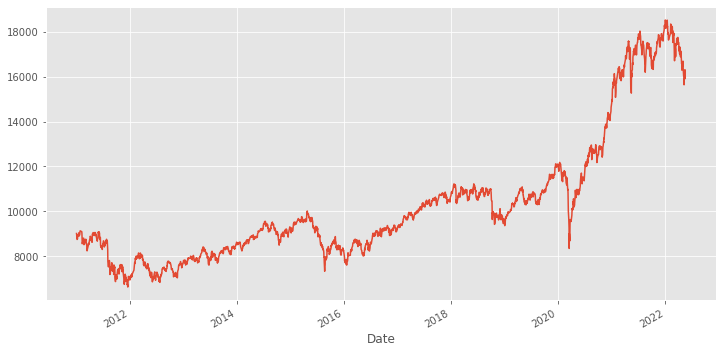

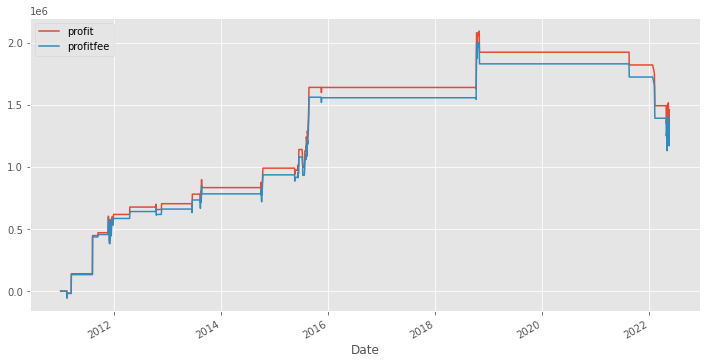

In [61]:
fund = 1000000
feePaid = 600
span =30
position = 3
pc1 =130
pc2 = 80
txf1=1000
txf2 = -1750

BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = [0]

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break
        
    ## 進場邏輯
    filter_entrylong = df_arr[i,8]>=df_arr[i-1,8]
    filter_entryshort = df_arr[i,8]<=df_arr[i-1,8]<=df_arr[i-2,8] and df_arr[i-2,8]<=-(txf2)
    entryLong = df_arr[i,3] > df_arr[i,9] and df_arr[i,5]>=df_arr[i-1,5]>=df_arr[i-2,5]and df_arr[i,5]>=pc1# and filter_entrylong 
    entrySellShort = df_arr[i,3] < df_arr[i,9] and df_arr[i,5]<=pc2 and df_arr[i,5]<=df_arr[i-1,5]
    entryCondition = date_arr[i] not in settlementDate
    
    ## 出場邏輯 
    filter_exitshort = df_arr[i,8]<=df_arr[i-1,8] <=df_arr[i-2,8] 
    filter_buytocover =df_arr[i,8]>=df_arr[i-1,8] >=df_arr[i-2,8]
    exitShort = df_arr[i,3] <= df_arr[i,9] and filter_exitshort
    exitBuyToCover = df_arr[i,3] >= df_arr[i,9] and filter_buytocover
    exitCondition = date_arr[i] in settlementDate #and df_arr[i,5] >= 11
    ##部位說明
    #if not(list(pd.Series(profit_fee_list_realized).cumsum()) == []):
#     if list(pd.Series(profit_fee_list_realized).cumsum())[-1]<400000:
#         position = 2
#     if 400000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<800000:
#         position = 3
#     if 800000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<1200000:
#         position = 4
#     if 1200000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<1600000:
#         position = 5
#     if 1600000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<2000000:
#         position = 6
#     if 2000000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<2400000:
#         position = 7 
#     if 2400000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<2800000:
#         position = 8
#     if 2800000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<3200000:
#         position = 9
#     if 3200000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<3600000:
#         position = 10
#     if 3600000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<4000000:
#         position = 11
#     if 4000000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<4400000:
#         position = 12
#     if 4400000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<4800000:
#         position = 13
    ##不交易
    
    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K)
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
    elif BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+K)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        
#         if entryLong and entryCondition:
#             BS = 'B'
#             t = i+1
#             buy.append(t)

        if entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            sellshort.append(t)
            
    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])*position
        profit_list.append(profit)
            
        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])*position
            profit_fee = profit - feePaid*2*position
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2*position
            profit_fee_list_realized.append(profit_fee_realized)
             
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
    elif BS == 'S': 
        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])*position
        profit_list.append(profit)
        
        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])*position
            profit_fee = profit - feePaid*2*position
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2*position
            profit_fee_list_realized.append(profit_fee_realized)
 
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
            
equity = pd.DataFrame([list(pd.Series(profit_list).cumsum()),list(pd.Series(profit_fee_list).cumsum())]).T
tradeTimes = len(buy)+len(sellshort)
equity.index=allData.index
equity.columns=['profit','profitfee']
print(equity)
print(f'tradeTimes: {tradeTimes}')
allData['close'].plot(grid=True, figsize=(12,6));
equity.plot(grid=True, figsize=(12,6));
#std atr

# opmization  

In [62]:
trainData

,open,high,low,close,volume,pc_ratio,空方未平倉口數,多方未平倉口數,多空未平倉口數淨額,EMA_30
Date,,,,,,,,,,
2011-01-03,9000.0,9030.0,8995.0,9019.0,61365.0,128.13,58448,35745,-2538,9019.000000
2011-01-04,9030.0,9030.0,8974.0,8978.0,62448.0,126.30,60104,32808,-4869,8997.816667
2011-01-05,8967.0,9005.0,8791.0,8838.0,165831.0,117.69,58497,31203,-775,8940.954832
2011-01-06,8859.0,8876.0,8815.0,8869.0,82510.0,114.87,58141,30722,-346,8921.128653
2011-01-07,8866.0,8883.0,8727.0,8753.0,128752.0,113.53,55365,30964,2754,8882.875314
...,...,...,...,...,...,...,...,...,...,...
2019-12-25,11989.0,12027.0,11976.0,12020.0,41574.0,122.63,81781,93260,184,11750.762813
2019-12-26,12029.0,12042.0,11986.0,12009.0,52147.0,123.62,88412,93366,-6525,11767.423277
2019-12-27,12038.0,12112.0,12037.0,12097.0,74436.0,138.47,86617,98017,6455,11788.686291


In [63]:
df_arr = np.array(trainData)
time_arr = np.array(trainData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]

In [64]:
optimizationList = []

fund = 1000000
feePaid = 600
length = 15
NumStd = 1.5
K = 0.02
span =30
position = 2
# pc1=130
# pc2 = 80
for pc1 in np.arange(80,150,5):
    for pc2 in np.arange(70,105,5):
        
        
        print('----------')
        print(f'pc1: {pc1}')
        print(f'pc2: {pc2}')

        

        BS = None
        buy = []
        sell = []
        sellshort = []
        buytocover = []
        profit_list = [0]
        profit_fee_list = [0]
        profit_fee_list_realized = [0]


        for i in range(len(df_arr)):

            if i == len(df_arr)-1:
                break

            ## 進場邏輯
            filter_entrylong = df_arr[i,8]>=df_arr[i-1,8]# >= df_arr[i-2,8]>=df_arr[i-3,8]
            filter_entryshort = df_arr[i,8]<= 18000
            entryLong = df_arr[i,3] > df_arr[i,9] and df_arr[i,5]>=df_arr[i-1,5]>=df_arr[i-2,5]and df_arr[i,5]>=pc1  
            entrySellShort = df_arr[i,3] < df_arr[i,9] and df_arr[i,5]<=pc2 and df_arr[i,5]<=df_arr[i-1,5]<=df_arr[i-2,5]
            entryCondition = date_arr[i] not in settlementDate

            ## 出場邏輯 
            filter_exitshort = df_arr[i,8]<=df_arr[i-1,8] <=df_arr[i-2,8]
            filter_buytocover =df_arr[i,8]>=df_arr[i-1,8] >=df_arr[i-2,8]
            exitShort = df_arr[i,3] <= df_arr[i,9] and filter_exitshort
            exitBuyToCover = df_arr[i,3] >= df_arr[i,9] and filter_buytocover
            exitCondition = date_arr[i] in settlementDate #and df_arr[i,5] >= 11
            
            ##部位說明
#             if list(pd.Series(profit_fee_list_realized).cumsum())[-1]<400000:
#                 position = 2
#             if 400000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<800000:
#                 position = 3
#             if 800000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<1200000:
#                 position = 4
#             if 1200000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<1600000:
#                 position = 5
#             if 1600000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<2000000:
#                 position = 6
#             if 2000000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<2400000:
#                 position = 6 
#             if 2400000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<2800000:
#                 position = 7
#             if 2800000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<3200000:
#                 position = 8
#             if 3200000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<3600000:
#                 position = 9
#             if 3600000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<4000000:
#                 position = 10
#             if 4000000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<4400000:
#                 position = 11
#             if 4400000<=list(pd.Series(profit_fee_list_realized).cumsum())[-1]<4800000:
#                 position = 12
            ## 停利停損邏輯
            if BS == 'B':
                stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K)
                stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
            elif BS == 'S':
                stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+K)
                stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)

        #     if exitCondition == True:
        #         print(f'{time_arr[i]}')

            if BS == None:
                profit_list.append(0)
                profit_fee_list.append(0)

                if entryLong and entryCondition:
                    BS = 'B'
                    t = i+1
                    buy.append(t)

                elif entrySellShort and entryCondition:
                    BS = 'S'
                    t = i+1
                    sellshort.append(t)

            elif BS == 'B':
                profit = 200 * (df_arr[i+1,0] - df_arr[i,0])*position
                profit_list.append(profit)

                if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
                    pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])*position
                    profit_fee = profit - feePaid*2*position
                    profit_fee_list.append(profit_fee)
                    sell.append(i+1)
                    BS=None

                    # Realized PnL
                    profit_fee_realized = pl_round - feePaid*2*position
                    profit_fee_list_realized.append(profit_fee_realized)

                else:
                    profit_fee = profit
                    profit_fee_list.append(profit_fee)

            elif BS == 'S': 
                profit = 200 * (df_arr[i,0] - df_arr[i+1,0])*position
                profit_list.append(profit)

                if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
                    pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])*position
                    profit_fee = profit - feePaid*2*position
                    profit_fee_list.append(profit_fee)
                    buytocover.append(i+1)
                    BS=None

                    # Realized PnL
                    profit_fee_realized = pl_round - feePaid*2*position
                    profit_fee_list_realized.append(profit_fee_realized)

                else:
                    profit_fee = profit
                    profit_fee_list.append(profit_fee)



        equity = pd.DataFrame([list(pd.Series(profit_list).cumsum()),list(pd.Series(profit_fee_list).cumsum())]).T
        equity.index=trainData.index
        equity.columns=['profit','profitfee']
        equity['equity'] = equity['profitfee'] + fund
        equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
        equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
        ret = equity['equity'][-1]/equity['equity'][0] - 1
        mdd = abs(equity['drawdown_percent'].min())
        calmarRatio = ret / mdd
        
        optimizationList.append([pc1, pc2, ret, calmarRatio])

----------
pc1: 80
pc2: 70
----------
pc1: 80
pc2: 75
----------
pc1: 80
pc2: 80
----------
pc1: 80
pc2: 85
----------
pc1: 80
pc2: 90
----------
pc1: 80
pc2: 95
----------
pc1: 80
pc2: 100
----------
pc1: 85
pc2: 70
----------
pc1: 85
pc2: 75
----------
pc1: 85
pc2: 80
----------
pc1: 85
pc2: 85
----------
pc1: 85
pc2: 90
----------
pc1: 85
pc2: 95
----------
pc1: 85
pc2: 100
----------
pc1: 90
pc2: 70
----------
pc1: 90
pc2: 75
----------
pc1: 90
pc2: 80
----------
pc1: 90
pc2: 85
----------
pc1: 90
pc2: 90
----------
pc1: 90
pc2: 95
----------
pc1: 90
pc2: 100
----------
pc1: 95
pc2: 70
----------
pc1: 95
pc2: 75
----------
pc1: 95
pc2: 80
----------
pc1: 95
pc2: 85
----------
pc1: 95
pc2: 90
----------
pc1: 95
pc2: 95
----------
pc1: 95
pc2: 100
----------
pc1: 100
pc2: 70
----------
pc1: 100
pc2: 75
----------
pc1: 100
pc2: 80
----------
pc1: 100
pc2: 85
----------
pc1: 100
pc2: 90
----------
pc1: 100
pc2: 95
----------
pc1: 100
pc2: 100
----------
pc1: 105
pc2: 70
----------
pc1:

In [65]:
optResult = pd.DataFrame(optimizationList, columns=['pc1','pc2','ret','calmarRatio'])
optResult

,pc1,pc2,ret,calmarRatio
0,80,70,0.9208,1.913757
1,80,75,1.2428,2.572287
2,80,80,1.5468,4.825957
3,80,85,1.5700,4.073346
4,80,90,1.6432,4.051923
...,...,...,...,...
93,145,80,1.5508,6.566179
94,145,85,1.5780,6.764785
95,145,90,1.6312,7.510370
96,145,95,0.9564,2.757346


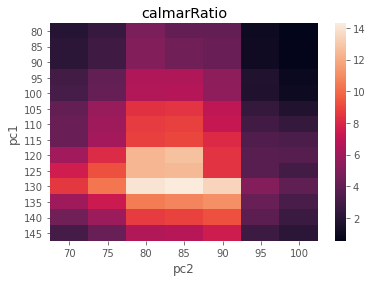

In [66]:
pic = optResult.pivot('pc1', 'pc2', 'calmarRatio')
sns.heatmap(data = pic).set(title='calmarRatio');

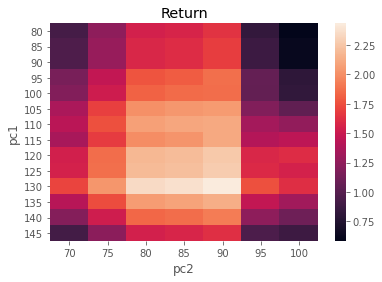

In [67]:
pic = optResult.pivot('pc1', 'pc2', 'ret')
sns.heatmap(data = pic).set(title='Return');